In [1]:
import numpy as np
import math as math
#import random as pyrandom
#from scipy import spatial

# Функция переводит считываемый .txt файл (аргумент str)
# без первой строчки (не содержащей данных) в список python 
# (обект типа list); аргумент m отвечает за то, 
# сколько в начале идет переменных int-типа; аргумент M был введен,
# чтобы не считывать не нужную информацию 
def rd(str,m = 100, M = 100):
    with open(str) as f:
        polyShape = []
        k = 0
        for line in f:
            if k > 0:
                line = line.strip()
                line = line.split(",")
                newline = line[:min(M,len(line))] # to deal with blank 
                if newline:            # lines (ie skip them)
                    newline = [float(i) for i in newline]
                    l = len(newline)
                    ml = min(l,m)
                    for i in range(0,ml):
                        newline[i] = int(newline[i])
                    polyShape.append(newline + line[min(M,len(newline)):])
            k = k + 1
    return polyShape


# atoms.txt Содержит информацию об атомах, в колонках следующие данные:
# ID, x, y, z, сигма, эпсилон, заряд, 
# радиус Ван-дер-Ваальса, объём и еще две колонки типа строки; 
# радиус и объем и эти две колонки не используются далее
atoms = rd('atoms.txt',1,9) # вместо 9 можно было и 7 взять

#bonds.txt Содержит информацию о связях, структура файла:
# ID1, ID2, Kr, r0
bonds = rd('bonds.txt',2)

# angles.txt Содержит информацию об углах, структура файла:
# ID1, ID2, ID3, Kt, theta0
angles = rd('angles.txt',3)

# dihedrals.txt Содержит информацию о двугранных углах, структура:
# ID1, ID2, ID3, ID4, V1, V2, V3, V4
# Все константы V1, V2, V3, V4 разделены на два, 
# при вычислении энергии делить их на два НЕ НАДО.
dihedrals = rd('dihedrals.txt',4)

# neighbours.txt, two_bonds_neigh.txt, three_bonds_neigh.txt
# Содержат информацию о соседях непосредственных, 
# второго и третьего порядка соответственно. 
# У всех одна и та же структура:
# ID    id_1 id_2 ... id_n
# ID – индекс атома, id_1 id_2 ... id_n – индексы его соседей.
neighbours = rd('neighbours.txt')
two_bonds_neigh = rd('two_bonds_neigh.txt')
three_bonds_neigh = rd('three_bonds_neigh.txt')

# По координатам 4-х точек рассчитывается косинус диэдрального угла, ими образованного
def dihedral(v1,v2,v3,v4):
    v1 = np.array(v1)
    v2 = np.array(v2)
    v3 = np.array(v3)
    v4 = np.array(v4)
    vm = (v2 + v3)/2
    vm1 = v1 - vm
    vm4 = v4 - vm
    v23 = v3 - v2
    sp1 = vm1 - v23*(vm1.dot(v23)/v23.dot(v23))
    sp2 = vm4 - v23*(vm4.dot(v23)/v23.dot(v23))
    cos = sp1.dot(sp2)/(np.linalg.norm(sp1)*np.linalg.norm(sp2))
    return cos

# По координатам 3-х точек рассчитывается угл, ими образованный
def angle(v1,v2,v3):
    vv1 = np.array(v1) - np.array(v2)
    vv2 = np.array(v3) - np.array(v2)
    cos = vv1.dot(vv2)/(np.linalg.norm(vv1)*np.linalg.norm(vv2))
    acos = np.arccos(cos)
    return acos

# Расчитываются константы f_ij в E_{nonbonded}
def f_ij(neighbours, two_bonds_neigh, three_bonds_neigh, i, j):
    for idx in neighbours[i]:
        if idx == j:
            return 0
    for idx in two_bonds_neigh[i]:
        if idx == j:
            return 0
    for idx in three_bonds_neigh[i]:
        if idx == j:
            return 0.5
    return 1

# Далее вычисляются отдельные составляющие OPLS force field
def E_dihedral(atoms, dihedrals):
    N = len(dihedrals)
    E = 0
    for k in range(0,N):
        cos = dihedral(atoms[dihedrals[k][0]][1:4],atoms[dihedrals[k][1]][1:4],atoms[dihedrals[k][2]][1:4],atoms[dihedrals[k][3]][1:4])
        E = E + dihedrals[k][4]*(1 + cos)
        E = E + 2*dihedrals[k][5]*(1 - pow(cos,2))
        E = E + dihedrals[k][6]*(1 + 4*pow(cos,3) - 3*cos)
        E = E + 8*dihedrals[k][7]*(pow(cos,2) - pow(cos,4))
    return E * 4.184

def E_angle(atoms,angles):
    N = len(angles)
    E = 0
    for k in range(0,N):
        E = E + angles[k][3]*pow(angle(atoms[angles[k][0]][1:4],atoms[angles[k][1]][1:4],atoms[angles[k][2]][1:4]) - angles[k][4],2)
    return E * 4.184

def E_bonds(atoms,bonds):
    N = len(bonds)
    E = 0
    for k in range(0,N):
        r = np.array(atoms[bonds[k][0]][1:4]) - np.array(atoms[bonds[k][1]][1:4])  
        E = E + bonds[k][2]*pow(np.linalg.norm(r) - bonds[k][3],2)
    return E * 4.184

# 1389.38757 – константа, учитывающая 1/(4πε0), множитель 10^(-10) 
# – перевод ангстремов в метры,
# заряды электронов и перевод ккал/моль в кДж/моль
def E_elst(atoms, neighbours, two_bonds_neigh, three_bonds_neigh):
    N = len(atoms)
    E = 0
    for i in range(0,N):
        for j in range(i + 1,N):
            f = f_ij(neighbours, two_bonds_neigh, three_bonds_neigh, i, j)
            if f == 0:
                continue
            else:
                r = np.array(atoms[i][1:4]) - np.array(atoms[j][1:4])
                E = E + f * atoms[i][6] * atoms[j][6] / np.linalg.norm(r)
    return E * 1389.38757

# Для получения формулы из Википедии https://en.wikipedia.org/wiki/OPLS:
# Раскрыть скобки и подставить
# A = eps * (sig ^ 6)
# C = eps * (sig ^ 3)
# Формула переделана для уменьшения числа арифметических операций 
# и соответствия параметрам, которые предоставляет OPLS
# 4 * 4.184 – перевод ккал/моль в кДж/моль
def E_vdw(atoms, neighbours, two_bonds_neigh, three_bonds_neigh):
    N = len(atoms)
    E = 0
    for i in range(0,N):
        for j in range(i + 1,N):
            f = f_ij(neighbours, two_bonds_neigh, three_bonds_neigh, i, j)
            if f == 0:
                continue
            else:
                eps = math.sqrt(atoms[i][5] * atoms[j][5])
                sig = atoms[i][4] * atoms[j][4]
                dist = np.linalg.norm(np.array(atoms[i][1:4]) - np.array(atoms[j][1:4]))
                sigSqDivR = (sig / dist ** 2) ** 3
                E = E + f * eps * sigSqDivR * (sigSqDivR - 1)
    return E * 4 * 4.184

# OPLS force field
def E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh):
    E = E_dihedral(atoms, dihedrals) + E_angle(atoms,angles) + E_bonds(atoms,bonds)+ E_elst(atoms, neighbours, two_bonds_neigh, three_bonds_neigh) + E_vdw(atoms, neighbours, two_bonds_neigh, three_bonds_neigh)
    return E

print(E_angle(atoms, angles)) 
print(E_dihedral(atoms, dihedrals))
print(E_bonds(atoms,bonds))      
print(E_elst(atoms, neighbours, two_bonds_neigh, three_bonds_neigh))
print(E_vdw(atoms, neighbours, two_bonds_neigh, three_bonds_neigh))
print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh))

1022.65545123
1345.03192536
255.683340914
-25668.1765882
-1539.69210732
-24584.497978


In [2]:
# Начинаем описывать функции, необходимые для расчета градиента OPLS force field
def angle_d(v1,v2,v3):
    vv1 = np.array(v1) - np.array(v2)
    vv2 = np.array(v3) - np.array(v2)
    
    cos = vv1.dot(vv2)/(np.linalg.norm(vv1)*np.linalg.norm(vv2))
    
    cos_dv1 = vv2/(np.linalg.norm(vv1)*np.linalg.norm(vv2)) - \
    vv1*vv1.dot(vv2)/(pow(np.linalg.norm(vv1),3)*np.linalg.norm(vv2))
    
    cos_dv2 = -(vv1 + vv2)/(np.linalg.norm(vv1)*np.linalg.norm(vv2)) + \
    vv1*vv1.dot(vv2)/(pow(np.linalg.norm(vv1),3)*np.linalg.norm(vv2)) + \
    vv2*vv1.dot(vv2)/(np.linalg.norm(vv1)*pow(np.linalg.norm(vv2),3))
    
    cos_dv3 = vv1/(np.linalg.norm(vv1)*np.linalg.norm(vv2)) - \
    vv2*vv1.dot(vv2)/(np.linalg.norm(vv1)*pow(np.linalg.norm(vv2),3))
    
    m = - 1 / pow(1 - pow(cos,2),1/2) # Производная арккосинуса
    r = []
    r.append(m*cos_dv1)
    r.append(m*cos_dv2)
    r.append(m*cos_dv3) 
    
    return r

In [3]:
# Ниже привордится совершенно очевидный код, тут даже нечего комментировать, все очевидно :) 
# только вот неделю ошибки тут вылавливал:) 
def dihedral_d(v1,v2,v3,v4):
    v1 = np.array(v1)
    v2 = np.array(v2)
    v3 = np.array(v3)
    v4 = np.array(v4)
    
    vm = (v2 + v3)/2
    vm1 = v1 - vm
    vm4 = v4 - vm
    v23 = v3 - v2
    
    vm_dv2 = np.array([1/2,1/2,1/2])
    vm_dv3 = np.array([1/2,1/2,1/2])
    
    vm1_dv1 = np.array([1,1,1])
    vm1_dv2 = - vm_dv2
    vm1_dv3 = - vm_dv3
    
    vm4_dv4 = np.array([1,1,1])
    vm4_dv2 = - vm_dv2
    vm4_dv3 = - vm_dv3
    
    v23_dv3 = np.array([1,1,1])
    v23_dv2 = - np.array([1,1,1])
    
    vm1dv1 = np.zeros((3, 3))
    np.fill_diagonal(vm1dv1, vm1_dv1)
    vm1dv2 = np.zeros((3, 3))
    np.fill_diagonal(vm1dv2, vm1_dv2)
    vm1dv3 = np.zeros((3, 3))
    np.fill_diagonal(vm1dv3, vm1_dv3)
    
    vm4dv2 = np.zeros((3, 3))
    np.fill_diagonal(vm4dv2, vm4_dv2)
    vm4dv3 = np.zeros((3, 3))
    np.fill_diagonal(vm4dv3, vm4_dv3)
    vm4dv4 = np.zeros((3, 3))
    np.fill_diagonal(vm4dv4, vm4_dv4)
    
    v23dv3 = np.zeros((3, 3))
    np.fill_diagonal(v23dv3, v23_dv3)
    v23dv2 = np.zeros((3, 3))
    np.fill_diagonal(v23dv2, v23_dv2)
    
    sp1 = vm1 - v23*(vm1.dot(v23)/pow(np.linalg.norm(v23),2))
    sp2 = vm4 - v23*(vm4.dot(v23)/pow(np.linalg.norm(v23),2))
    
    sp1_dv1 = vm1dv1 - np.outer(v23,v23)/pow(np.linalg.norm(v23),2)
    sp1_dv2 = vm1dv2 - v23dv2*(vm1.dot(v23)/pow(np.linalg.norm(v23),2)) -\
    (-1/2)*np.outer(v23,v23)/pow(np.linalg.norm(v23),2) -\
    (-1)*np.outer(vm1,v23)/pow(np.linalg.norm(v23),2) - \
    np.outer(v23,v23)*(vm1.dot(v23)/pow(np.linalg.norm(v23),4)) 
    sp1_dv3 = vm1dv3 - v23dv3*(vm1.dot(v23)/pow(np.linalg.norm(v23),2)) -\
    (-1/2)*np.outer(v23,v23)/pow(np.linalg.norm(v23),2) -\
    np.outer(vm1,v23)/pow(np.linalg.norm(v23),2) - \
    (-1)*np.outer(v23,v23)*(vm1.dot(v23)/pow(np.linalg.norm(v23),4))
    
    sp2_dv2 = vm4dv2 - v23dv2*(vm4.dot(v23)/pow(np.linalg.norm(v23),2)) -\
    (-1/2)*np.outer(v23,v23)/pow(np.linalg.norm(v23),2) -\
    (-1)*np.outer(vm4,v23)/pow(np.linalg.norm(v23),2) - \
    np.outer(v23,v23)*(vm4.dot(v23)/pow(np.linalg.norm(v23),4)) 
    sp2_dv3 = vm4dv3 - v23dv3*(vm4.dot(v23)/pow(np.linalg.norm(v23),2)) -\
    (-1/2)*np.outer(v23,v23)/pow(np.linalg.norm(v23),2) -\
    np.outer(vm4,v23)/pow(np.linalg.norm(v23),2) - \
    (-1)*np.outer(v23,v23)*(vm4.dot(v23)/pow(np.linalg.norm(v23),4))
    sp2_dv4 = vm4dv4 - np.outer(v23,v23)/pow(np.linalg.norm(v23),2)
    
    cos = sp1.dot(sp2)/(np.linalg.norm(sp1)*np.linalg.norm(sp2))
    
    cos_dv1 = sp1_dv1.dot(sp2)/(np.linalg.norm(sp1)*np.linalg.norm(sp2)) - \
    sp1_dv1.dot(sp1)*sp1.dot(sp2)/(pow(np.linalg.norm(sp1),3)*np.linalg.norm(sp2))
    
    cos_dv2 = (sp1_dv2.dot(sp2) + sp2_dv2.dot(sp1))/(np.linalg.norm(sp1)*np.linalg.norm(sp2)) -\
    sp1_dv2.dot(sp1)*sp1.dot(sp2)/(pow(np.linalg.norm(sp1),3)*np.linalg.norm(sp2)) - \
    sp2_dv2.dot(sp2)*sp1.dot(sp2)/(np.linalg.norm(sp1)*pow(np.linalg.norm(sp2),3))
    
    cos_dv3 = (sp1_dv3.dot(sp2) + sp2_dv3.dot(sp1))/(np.linalg.norm(sp1)*np.linalg.norm(sp2)) - \
    sp1_dv3.dot(sp1)*sp1.dot(sp2)/(pow(np.linalg.norm(sp1),3)*np.linalg.norm(sp2)) - \
    sp2_dv3.dot(sp2)*sp1.dot(sp2)/(np.linalg.norm(sp1)*pow(np.linalg.norm(sp2),3))
    
    cos_dv4 = sp2_dv4.dot(sp1)/(np.linalg.norm(sp1)*np.linalg.norm(sp2)) - \
    sp2_dv4.dot(sp2)*sp1.dot(sp2)/(np.linalg.norm(sp1)*pow(np.linalg.norm(sp2),3))
    
    r = []
    r.append(cos_dv1)
    r.append(cos_dv2)
    r.append(cos_dv3)
    r.append(cos_dv4)
    
    return r

In [4]:
def E_dihedral_d(atoms, dihedrals):
    N = len(dihedrals)
    l = len(atoms)
    c = [[] for k in range(0,l)]
    for i in range(0,l):
        c[i] = np.array([0.0,0.0,0.0])
    for k in range(0,N):
        cos = dihedral(atoms[dihedrals[k][0]][1:4],atoms[dihedrals[k][1]][1:4],atoms[dihedrals[k][2]][1:4],atoms[dihedrals[k][3]][1:4])
        cos_d = dihedral_d(atoms[dihedrals[k][0]][1:4],atoms[dihedrals[k][1]][1:4],atoms[dihedrals[k][2]][1:4],atoms[dihedrals[k][3]][1:4])
        for j in range(0,4):
            c[dihedrals[k][j]] = c[dihedrals[k][j]] + 4.184*dihedrals[k][4]*cos_d[j] # E = E + dihedrals[k][4]*(1 + cos)
            c[dihedrals[k][j]] = c[dihedrals[k][j]] - 4.184*2*dihedrals[k][5]*2*cos*cos_d[j] #E = E + 2*dihedrals[k][5]*(1 - pow(cos,2))
            c[dihedrals[k][j]] = c[dihedrals[k][j]] + 4.184*dihedrals[k][6]*(4*3*pow(cos,2)*cos_d[j] - 3*cos_d[j]) # E = E + dihedrals[k][6]*(1 + 4*pow(cos,3) - 3*cos)
            c[dihedrals[k][j]] = c[dihedrals[k][j]] + 4.184*8*dihedrals[k][7]*(2*cos*cos_d[j] - 4*pow(cos,3)*cos_d[j]) # E = E + 8*dihedrals[k][7]*(pow(cos,2) - pow(cos,4))                                                   
    return c

In [5]:
def E_angle_d(atoms,angles):
    N = len(angles)
    l = len(atoms)
    c = [[] for k in range(0,l)]
    for i in range(0,l):
        c[i] = np.array([0.0,0.0,0.0])
    for k in range(0,N):
        a = angle(atoms[angles[k][0]][1:4],atoms[angles[k][1]][1:4],atoms[angles[k][2]][1:4])
        a_d = angle_d(atoms[angles[k][0]][1:4],atoms[angles[k][1]][1:4],atoms[angles[k][2]][1:4])
        for j in range(0,3):
            c[angles[k][j]] = c[angles[k][j]] + 4.184*angles[k][3]*2*(a - angles[k][4])*a_d[j] # E = E + angles[k][3]*pow(angle(atoms[angles[k][0]][1:4],atoms[angles[k][1]][1:4],atoms[angles[k][2]][1:4]) - angles[k][4],2)
    return c

In [6]:
def E_bonds_d(atoms,bonds):
    N = len(bonds)
    l = len(atoms)
    c = [[] for k in range(0,l)]
    for i in range(0,l):
        c[i] = np.array([0.0,0.0,0.0])
    for k in range(0,N):
        r = np.array(atoms[bonds[k][0]][1:4]) - np.array(atoms[bonds[k][1]][1:4])  
        c[bonds[k][0]]  = c[bonds[k][0]] + 4.184*bonds[k][2]*2*(np.linalg.norm(r) - bonds[k][3])*r / np.linalg.norm(r) # E = E + bonds[k][2]*pow(np.linalg.norm(r) - bonds[k][3],2)
        c[bonds[k][1]]  = c[bonds[k][1]] - 4.184*bonds[k][2]*2*(np.linalg.norm(r) - bonds[k][3])*r / np.linalg.norm(r)
    return c

In [7]:
def E_elst_d(atoms, neighbours, two_bonds_neigh, three_bonds_neigh):
    N = len(atoms)
    c = [[] for k in range(0,N)]
    for i in range(0,N):
        c[i] = np.array([0.0,0.0,0.0])
    for i in range(0,N):
        for j in range(i + 1,N):
            f = f_ij(neighbours, two_bonds_neigh, three_bonds_neigh, i, j)
            if f == 0:
                continue
            else:
                r = np.array(atoms[i][1:4]) - np.array(atoms[j][1:4])
                c[i] = c[i] - 1389.38757 * f * atoms[i][6] * atoms[j][6] * r / pow(np.linalg.norm(r),3) # E = E + f * atoms[i][6] * atoms[j][6] / np.linalg.norm(r)
                c[j] = c[j] + 1389.38757 * f * atoms[i][6] * atoms[j][6] * r / pow(np.linalg.norm(r),3)
    return c

In [8]:
def E_vdw_d(atoms, neighbours, two_bonds_neigh, three_bonds_neigh):
    N = len(atoms)
    c = [[] for k in range(0,N)]
    for i in range(0,N):
        c[i] = np.array([0.0,0.0,0.0])
    for i in range(0,N):
        for j in range(i + 1,N):
            f = f_ij(neighbours, two_bonds_neigh, three_bonds_neigh, i, j)
            if f == 0:
                continue
            else:
                eps = math.sqrt(atoms[i][5] * atoms[j][5])
                sig = atoms[i][4] * atoms[j][4]
                r = np.array(atoms[i][1:4]) - np.array(atoms[j][1:4])
                dist = np.linalg.norm(r)
                sigSqDivR = (sig / dist ** 2) ** 3
                sigSqDivR_di = - 6 * (sig ** 3) * r / (dist ** 8)
                sigSqDivR_dj = 6 * (sig ** 3) * r / (dist ** 8)
                c[i] = c[i] + 4 * 4.184 * f * eps * (2*sigSqDivR * sigSqDivR_di - sigSqDivR_di) # E = E + f * eps * sigSqDivR * (sigSqDivR - 1)
                c[j] = c[j] + 4 * 4.184 * f * eps * (2*sigSqDivR * sigSqDivR_dj - sigSqDivR_dj)
    return c


In [9]:
def E_d(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh):
    N = len(atoms)
    c = [[] for k in range(0,N)]
    for i in range(0,N):
        c[i] = np.array([0.0,0.0,0.0])
    E_d_d = E_dihedral_d(atoms, dihedrals)
    E_a_d = E_angle_d(atoms,angles)
    E_b_d = E_bonds_d(atoms,bonds)
    E_e_d = E_elst_d(atoms, neighbours, two_bonds_neigh, three_bonds_neigh)
    E_v_d = E_vdw_d(atoms, neighbours, two_bonds_neigh, three_bonds_neigh)
    for k in range(0,N):
        c[k] = c[k] + E_d_d[k] + E_a_d[k] + E_b_d[k] + E_e_d[k] + E_v_d[k]
    return c

189.022014911
-24584.497978


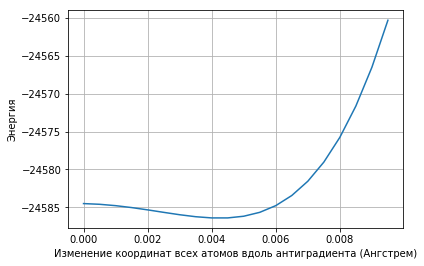

In [10]:
#Эта ячейка нужна, чтобы визуально понимать как функция себя ведет вдоль антиградиента 
# это нужно, чтобы правильно выбрать шаг уже в самом методе

v = E_d(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh)
print(np.linalg.norm(v))
v = - np.array(v) / np.linalg.norm(v)

ll = len(atoms)
hh = 0.0005
M = 20
mmm = []
ccc = []
atoms_old = atoms
print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh))
for k in range(0,M):
    for nm in range(0,ll):
        for coor in range(0,3):
            atoms[nm][coor + 1] = atoms_old[nm][coor + 1] + k*v[nm][coor]*hh
    EE = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh)
    mmm.append(EE)
    ccc.append(k*hh)  

import matplotlib.pyplot as plt
plt.plot(ccc,mmm)
plt.ylabel(r"Энергия")
plt.xlabel(r"Изменение координат всех атомов вдоль антиградиента (Ангстрем)")
plt.grid(True)
plt.show()

In [92]:
mas = []
for k in range(0,M):
    mas.append([ccc[k],mmm[k]])
import csv
with open('Result.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',lineterminator='\n')
    for i in mas:
            csvwriter.writerow(i)

In [10]:
import os
import csv
import time

# Эта функция описывает процедуру записи результатов расчетов в файл
def prp_atm(atoms,m):
    with open('atoms_out' + str(m) + '.csv', 'w') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',',lineterminator='\n')
        header = ['ID','x','y','z','sigma','epsilon','charge','Rvdw','volume','AA','PDB']
        csvwriter.writerow(header)
        for i in atoms:
            csvwriter.writerow(i)
            
# Эта функция нужна, чтобы следить за временем работы программы            
def millis():
    millis = int(round(time.time() * 1000))
    return millis

mas = []
tt = []
time_start = millis()

N = 100
l = len(atoms)
h = 0.01

for k in range(0,N):
    v = E_d(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh)
    v = - np.array(v) / np.linalg.norm(v)
    for nm in range(0,l):
        for coor in range(0,3):
            atoms[nm][coor + 1] = atoms[nm][coor + 1] + v[nm][coor]*h
    EE = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh)
    mas.append(EE)
    time_now = millis()
    ttm = (time_now - time_start)/60000
    tt.append(ttm)

prp_atm(atoms,N)
os.system('./to-pdb atoms_out' + str(N) + '.csv output' + str(N) + '.pdb')
        
import matplotlib.pyplot as plt
mmas = np.array(mas)
plt.plot(tt,mmas)
plt.xlabel(r"Время работы программы в минутах")
plt.ylabel(r"E")
plt.grid(True)
plt.show()

KeyboardInterrupt: 